In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
!pip install ydata-synthetic
!pip install tsaug
!pip install matplotlib==3.1.3
!pip install numpy==1.19

  Using cached https://files.pythonhosted.org/packages/87/a6/8d7d06f6b69236a3c1818157875ceb1259ba0d9df4194f4fe138ffdc0f41/matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/70/dc/e8c5e7983866fa4ef3fd619faa35f660b95b01a2ab62b3884f038ccab542/tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl
     |████████████████████████████████| 6.0MB 8.7MB/s 
  Using cached https://files.pythonhosted.org/packages/74/7e/622d9849abf3afb81e482ffc170758742e392ee129ce1540611199a59237/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.19.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
  Found existing installation: tensorboard 1.15.0
    Uninstalling tens

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: ydata-synthetic 0.3.0 has requirement matplotlib==3.3.2, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.3.2
    Uninstalling matplotlib-3.3.2:
      Successfully uninstalled matplotlib-3.3.2


In [17]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import *
import os
import numpy as np
import tensorflow as tf
import random as rn
import pandas as pd
from sklearn.model_selection import train_test_split
from tsaug.visualization import plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DepthwiseConv1D, Dense, TimeDistributed, AveragePooling1D, LSTM, Conv1D, Flatten, SeparableConv2D, Dropout, DepthwiseConv2D, MaxPooling2D, Activation, BatchNormalization, MaxPooling1D, Softmax, Input, Conv2D, AveragePooling2D
from numpy import genfromtxt
import scipy.io
import pandas as pd
import importlib
import sys  
from sklearn.preprocessing import MinMaxScaler
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans


from ydata_synthetic.synthesizers.timeseries import TimeGAN

os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)

#### READ DATA

In [18]:
mat = scipy.io.loadmat('subj1_train1.mat')
trials = np.swapaxes(mat['data'],0,2)
trials = np.swapaxes(trials,1,2)

mat1 = scipy.io.loadmat('subj1_train2.mat')

trials1 = np.swapaxes(mat1['data'],0,2)
trials1 = np.swapaxes(trials1,1,2)

mat2 = scipy.io.loadmat('subj2_train1.mat')

trials2 = np.swapaxes(mat2['data'],0,2)
trials2 = np.swapaxes(trials2,1,2)

mat3 = scipy.io.loadmat('subj2_train2.mat')

trials3 = np.swapaxes(mat3['data'],0,2)
trials3 = np.swapaxes(trials3,1,2)

trials = np.concatenate([trials, trials1, trials2, trials3])

labels_map = {0: '9Hz', 1: '10Hz', 
                2: '12Hz', 3: '15Hz'}

alt_labels_map = {0: 'TOP', 1: 'RIGHT', 
                2: 'BOTTOM', 3: 'LEFT'}

def read_labels (file_path, labels_map):
    oneHot_labels=genfromtxt(file_path,delimiter=' ')
    labels = np.argmax(oneHot_labels, axis=1)

    return labels, [labels_map[idx] for idx in labels]

labels = read_labels('classInfo_4_5.m', labels_map)

lab = labels[0].tolist()
for x in labels[0]:
  lab.append(x)
  lab.append(x)
  lab.append(x)

(<Figure size 1152x1152 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fee48ab6390>,
       dtype=object))

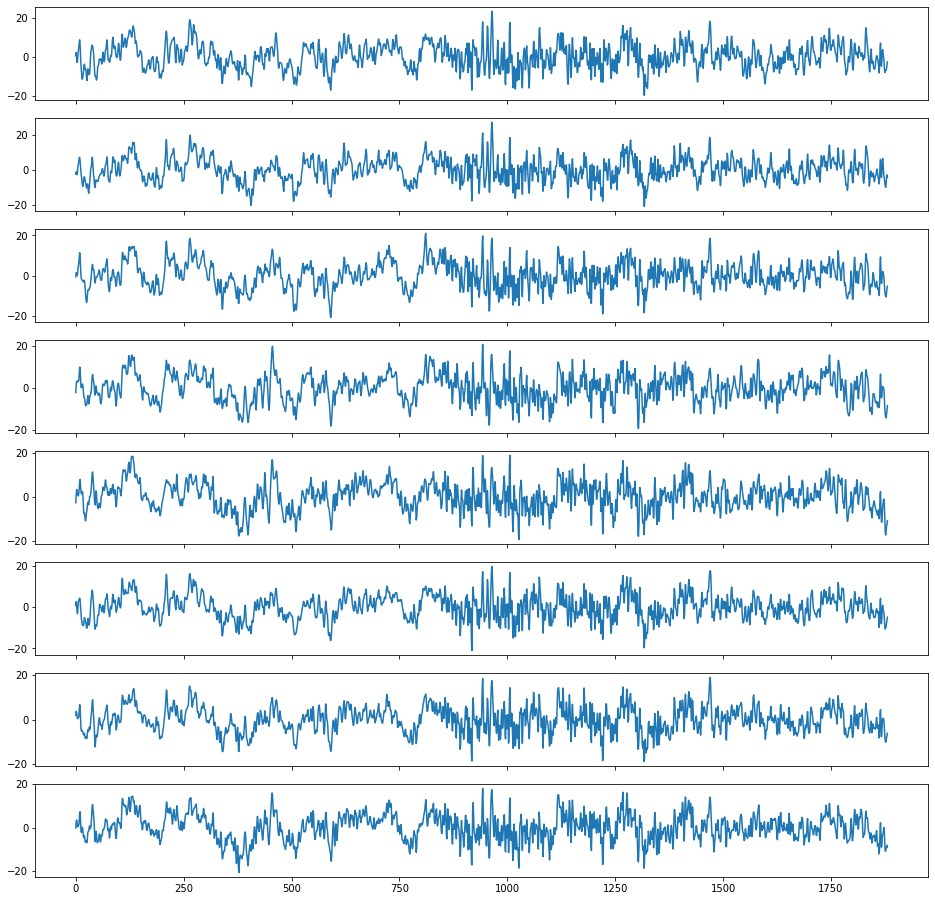

In [19]:
plot(trials[0])

#### TIMESERIES AUGMENTATION
Compute 10 new trials from every trial.

The methods used by the Augmenter apply a set of algorithms to modify the original data and create new, slighlty different timeseries.

The data produced from this will be used to train the TimeGAN model. We could also use this data to train the convolutional classifier but they are not diverse enough to achieve the generalization that we desire.

TODO:


*   Test other timeseries augmenter 




In [28]:
my_augmenter = (
TimeWarp() * 10  # random time warping 15 times in parallel
+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
+ Reverse() @ 0.5  # with 50% probability, reverse the sequence
)
trials_synt = my_augmenter.augment(trials)
labels_synt = []
for x in lab:
  for i in range(10):
    labels_synt.append(x)


trials_synt = np.array(trials_synt)
trials_synt.shape

(800, 8, 1882)

(<Figure size 1152x1152 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fee44c57cd0>,
       dtype=object))

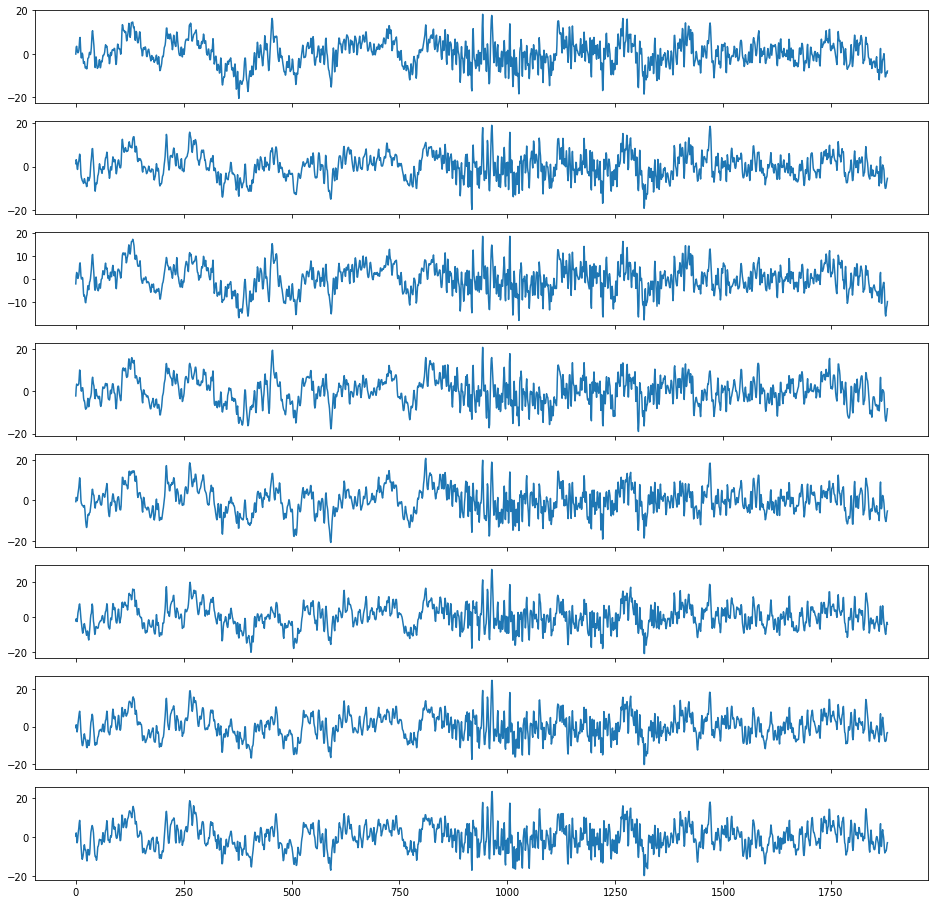

In [38]:
plot(trials_synt[0])

#### RESHAPE AND CREATE TRAIN/TEST DATA FOR CNN

In [29]:
x_trials_synt = np.swapaxes(trials_synt, 1, 2)
y_train = to_categorical(labels_synt)

#trials1 = np.swapaxes(trials, 1, 2)
trials1 = trials
x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(trials1, lab, test_size= 0.2, random_state=42)
y_test_ft = to_categorical(y_test_ft)
y_train_ft = to_categorical(y_train_ft)

In [34]:
x_trials_synt = np.swapaxes(x_trials_synt, 1, 2)

x_trials_synt.shape

(800, 8, 1882)

#### DEFINE, TRAIN, FINE-TUNE, TEST OF CNN
TODO:


*   Hyperparameters search
*   Different architectures



In [51]:
# DEFINE HYPERPARAMETERS FOR CLASSIFICATION
nb_classes = 4
Chans = 8
Samples = 1882 
dropoutRate = 0.5
kernLength = 10
F1 = 256 
D = 1
F2 = 256
dropoutType = Dropout

#DEFINE MODEL

input1   = Input(shape = (8, 1882))
block1  = Conv1D(F1, kernLength, padding = 'same',
                  input_shape = (Chans, Samples))(input1)
block1 = BatchNormalization()(block1)
block1 = Conv1D(Chans, D, use_bias = False)(block1)
block1 = BatchNormalization()(block1)
block1= Activation('elu')(block1)
block1= AveragePooling1D(4)(block1)
block1= dropoutType(dropoutRate)(block1)
    
block2= Conv1D(F2, 16, padding = 'same')(block1)
block2= BatchNormalization()(block2)
block2= Activation('elu')(block2)
block2= AveragePooling1D(2)(block2)
block2= dropoutType(dropoutRate)(block2)
        
flatten= Flatten(name = 'flatten')(block2)
dense1 = Dense(600, name = 'dense1')(flatten)

dense= Dense(nb_classes, name = 'dense')(dense1)
softmax= Activation('softmax', name = 'softmax')(dense)
    
model = Model(inputs=input1, outputs=softmax)

#COMPILE MODEL
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

#TRAIN ON SYNTHETIC DATA
model.fit(x_trials_synt, y_train, epochs = 10, batch_size=16)
model.evaluate(x_test_ft, y_test_ft)

#FINE-TUNE ON TRIAL DATA
model.fit(x_train_ft, y_train_ft, epochs = 10, batch_size=1)
model.evaluate(x_test_ft, y_test_ft)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 8, 1882)]         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 256)            4818176   
_________________________________________________________________
batch_normalization_42 (Batc (None, 8, 256)            1024      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 8, 8)              2048      
_________________________________________________________________
batch_normalization_43 (Batc (None, 8, 8)              32        
_________________________________________________________________
activation_24 (Activation)   (None, 8, 8)              0         
_________________________________________________________________
average_pooling1d_3 (Average (None, 2, 8)              0   

[1.3757925033569336, 0.1875]

#### SCALE DATA TO [-1, 1]

TODO:


*   Different scalers



In [53]:
x_train = trials_synt
ls = []
for x in range(len(x_train)):
  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(x_train[x])
  ls.append(train_data)
x_train_gan = np.array(ls)

In [54]:
x_train_gan = np.swapaxes(x_train_gan, 1, 2)
x_train_gan.shape

(800, 1882, 8)

#### TRAIN TIMEGAN

Credits to https://github.com/jsyoon0823/TimeGAN

In [80]:
def MinMaxScaler(dataX):
    
    min_val = np.min(np.min(dataX, axis = 0), axis = 0)
    dataX = dataX - min_val
    
    max_val = np.max(np.max(dataX, axis = 0), axis = 0)
    dataX = dataX / (max_val + 1e-7)
    
    return dataX, min_val, max_val

#%% Start TGAN function (Input: Original data, Output: Synthetic Data)
tf.compat.v1.disable_eager_execution()

def tgan (dataX, parameters):
  
    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
        
    # Normalization
    if ((np.max(dataX) > 1) | (np.min(dataX) < 0)):
        dataX, min_val, max_val = MinMaxScaler(dataX)
        Normalization_Flag = 1
    else:
        Normalization_Flag = 0
     
    # Network Parameters
    hidden_dim   = parameters['hidden_dim'] 
    num_layers   = parameters['num_layers']
    iterations   = parameters['iterations']
    batch_size   = parameters['batch_size']
    module_name  = parameters['module_name']    # 'lstm' or 'lstmLN'
    z_dim        = parameters['z_dim']
    gamma        = 1
    
    #%% input place holders
    
    X = tf.compat.v1.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x")
    Z = tf.compat.v1.placeholder(tf.float32, [None, Max_Seq_Len, z_dim], name = "myinput_z")
    T = tf.compat.v1.placeholder(tf.int32, [None], name = "myinput_t")
    
    #%% Basic RNN Cell
          
    def rnn_cell(module_name):
      # GRU
        if (module_name == 'gru'):
            rnn_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM
        elif (module_name == 'lstm'):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM Layer Normalization
        elif (module_name == 'lstmLN'):
            rnn_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
        return rnn_cell
      
        
    #%% build a RNN embedding network      
    
    def embedder (X, T):      
      
        with tf.compat.v1.variable_scope("embedder", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
            
            H = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return H
      
    ##### Recovery
    
    def recovery (H, T):      
      
        with tf.compat.v1.variable_scope("recovery", reuse = tf.compat.v1.AUTO_REUSE):       
              
            r_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            r_outputs, r_last_states = tf.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
            
            X_tilde = tf.contrib.layers.fully_connected(r_outputs, data_dim, activation_fn=tf.nn.sigmoid) 

        return X_tilde
    
    
    
    #%% build a RNN generator network
    
    def generator (Z, T):      
      
        with tf.compat.v1.variable_scope("generator", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
            
            E = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return E
      
    def supervisor (H, T):      
      
        with tf.compat.v1.variable_scope("supervisor", reuse = tf.compat.v1.AUTO_REUSE):
            
            e_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers-1)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
            
            S = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return S
      
      
      
    #%% builde a RNN discriminator network 
    
    def discriminator (H, T):
      
        with tf.compat.v1.variable_scope("discriminator", reuse = tf.compat.v1.AUTO_REUSE):
            
            d_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
            
            Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
    
        return Y_hat   
    
    
    #%% Random vector generation
    def random_generator (batch_size, z_dim, T_mb, Max_Seq_Len):
      
        Z_mb = list()
        
        for i in range(batch_size):
            
            Temp = np.zeros([Max_Seq_Len, z_dim])
            
            Temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        
            Temp[:T_mb[i],:] = Temp_Z
            
            Z_mb.append(Temp_Z)
      
        return Z_mb
    
    #%% Functions
    
    # Embedder Networks
    H = embedder(X, T)
    X_tilde = recovery(H, T)
    
    # Generator
    E_hat = generator(Z, T)
    H_hat = supervisor(E_hat, T)
    H_hat_supervise = supervisor(H, T)
    
    # Synthetic data
    X_hat = recovery(H_hat, T)
    
    # Discriminator
    Y_fake = discriminator(H_hat, T)
    Y_real = discriminator(H, T)     
    Y_fake_e = discriminator(E_hat, T)
    
    # Variables        
    e_vars = [v for v in tf.trainable_variables() if v.name.startswith('embedder')]
    r_vars = [v for v in tf.trainable_variables() if v.name.startswith('recovery')]
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    s_vars = [v for v in tf.trainable_variables() if v.name.startswith('supervisor')]
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
    # Loss for the discriminator
    D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
    D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
    D_loss_fake_e = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
    D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
    # Loss for the generator
    # 1. Adversarial loss
    G_loss_U = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
    G_loss_U_e = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
    # 2. Supervised loss
    G_loss_S = tf.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,1:,:])
    
    # 3. Two Momments
    G_loss_V1 = tf.reduce_mean(tf.abs(tf.sqrt(tf.nn.moments(X_hat,[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(X,[0])[1] + 1e-6)))
    G_loss_V2 = tf.reduce_mean(tf.abs((tf.nn.moments(X_hat,[0])[0]) - (tf.nn.moments(X,[0])[0])))
    
    G_loss_V = G_loss_V1 + G_loss_V2
    
    # Summation
    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            
    # Loss for the embedder network
    E_loss_T0 = tf.losses.mean_squared_error(X, X_tilde)
    E_loss0 = 10*tf.sqrt(E_loss_T0)
    E_loss = E_loss0  + 0.1*G_loss_S
    
    # optimizer
    E0_solver = tf.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
    E_solver = tf.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
    GS_solver = tf.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   
        
    #%% Sessions    
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    #%% Embedding Learning
    
    print('Start Embedding Network Training')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
            
        # Train embedder        
        _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})
        
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) )        
            
    print('Finish Embedding Network Training')
    
    #%% Training Supervised Loss First
    
    print('Start Training with Supervised Loss Only')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)        
        
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
        
        # Train generator       
        _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
                           
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
                
    print('Finish Training with Supervised Loss Only')
    
    #%% Joint Training
    
    print('Start Joint Training')
    
    # Training step
    for itt in range(iterations):
      
        # Generator Training
        for kk in range(2):
          
            # Batch setting
            idx = np.random.permutation(No)
            train_idx = idx[:batch_size]     
            
            X_mb = list(dataX[i] for i in train_idx)
            T_mb = list(dataT[i] for i in train_idx)
            
            # Random vector generation
            Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
              
            # Train generator
            _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run([G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
            
            # Train embedder        
            _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
        #%% Discriminator Training
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
        
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
        
        # Random vector generation
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
            
        
        check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        # Train discriminator
        
        if (check_d_loss > 0.15):        
            _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        #%% Checkpoints
        if itt % 500 == 0:
            print('step: '+ str(itt) + 
                  ', d_loss: ' + str(np.round(step_d_loss,4)) + 
                  ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
                  ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
                  ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
                  ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
   
    
    print('Finish Joint Training')
    
    #%% Final Outputs
    
    Z_mb = random_generator(No, z_dim, dataT, Max_Seq_Len)
    
    X_hat_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: dataX, T: dataT})    
    
    #%% List of the final outputs
    
    dataX_hat = list()
    
    for i in range(No):
        Temp = X_hat_curr[i,:dataT[i],:]
        dataX_hat.append(Temp)
        
    # Renormalization
    if (Normalization_Flag == 1):
        dataX_hat = dataX_hat * max_val
        dataX_hat = dataX_hat + min_val
    
    return dataX_hat
    
parameters = {
    'hidden_dim':9,
    'num_layers':9, 
    'iterations':2000,
    'batch_size':16,
    'module_name':'lstm',
    'z_dim':9
}
tf.reset_default_graph()

timegan = tgan(trials_synt, parameters)

Start Embedding Network Training
step: 0, e_loss: 0.1359
step: 1000, e_loss: 0.0453
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0, s_loss: 0.4395
step: 1000, s_loss: 0.0048
Finish Training with Supervised Loss Only
Start Joint Training
step: 0, d_loss: 2.0794, g_loss_u: 0.6931, g_loss_s: 0.002, g_loss_v: 0.0711, e_loss_t0: 0.0679
step: 500, d_loss: 1.9126, g_loss_u: 1.0853, g_loss_s: 0.0014, g_loss_v: 0.0574, e_loss_t0: 0.0559
step: 1000, d_loss: 1.5722, g_loss_u: 0.8312, g_loss_s: 0.0005, g_loss_v: 0.0489, e_loss_t0: 0.047
step: 1500, d_loss: 1.9082, g_loss_u: 1.0952, g_loss_s: 0.0015, g_loss_v: 0.0724, e_loss_t0: 0.0679
Finish Joint Training


(<Figure size 1152x1152 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec50acce90>,
       dtype=object))

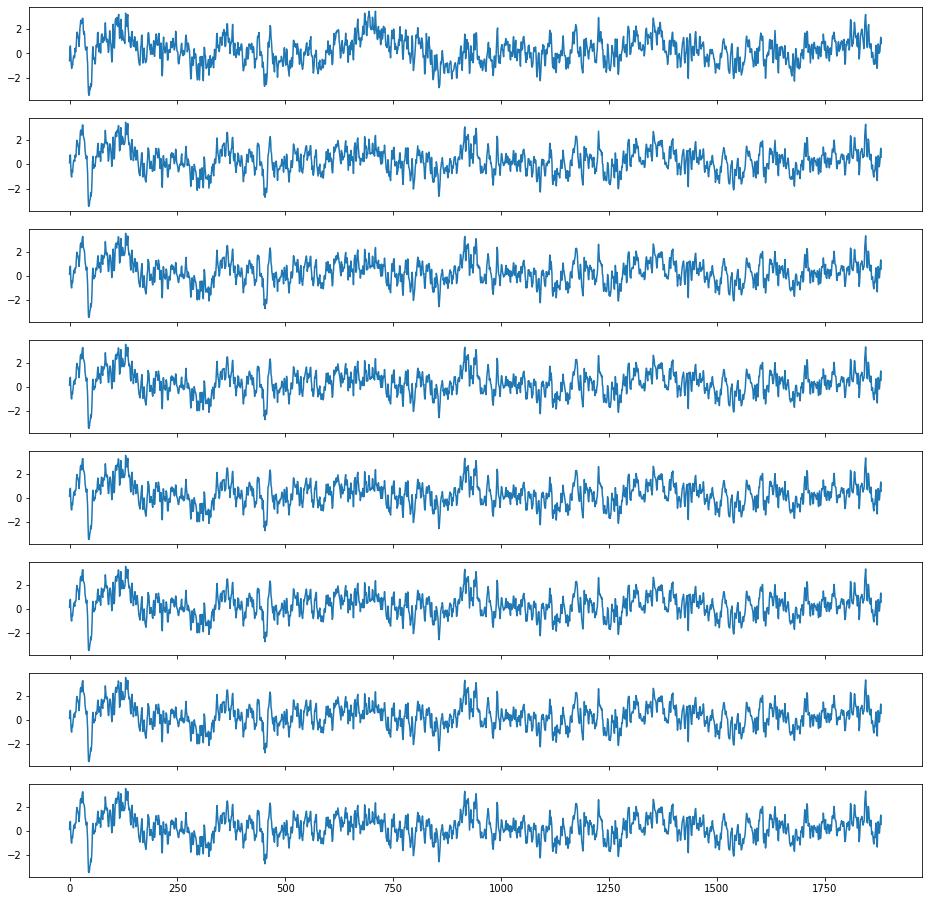

In [82]:
plot(timegan[0])